In [1]:
import pandas as pd
from pandas.io.json import json_normalize
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
import sys
from uszipcode import SearchEngine
import folium 
import requests
import time
import numpy as np
import sklearn
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import math
from scipy.spatial.distance import cdist 
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn import preprocessing
from yellowbrick.cluster import KElbowVisualizer
import seaborn as sns


c:\users\djaze\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#Importing the covid data from the newyork health department github
covid_df=pd.read_csv("https://raw.githubusercontent.com/nychealth/coronavirus-data/master/data-by-modzcta.csv")
covid_df.head()

,MODIFIED_ZCTA,NEIGHBORHOOD_NAME,BOROUGH_GROUP,COVID_CASE_COUNT,COVID_CASE_RATE,POP_DENOMINATOR,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE,TOTAL_COVID_TESTS
0,10001,Chelsea/NoMad/West Chelsea,Manhattan,421,1786.70,23563.03,25,106.10,7.05,5968
1,10002,Chinatown/Lower East Side,Manhattan,1233,1606.40,76755.41,160,208.45,10.11,12201
2,10003,East Village/Gramercy/Greenwich Village,Manhattan,516,959.08,53801.62,34,63.20,5.46,9451
3,10004,Financial District,Manhattan,39,1068.32,3650.61,1,27.39,6.07,642
4,10005,Financial District,Manhattan,79,940.91,8396.11,2,23.82,5.25,1504


In [3]:
#grouping the neighbourhoods if there are duplicates
covid=covid_df.groupby('NEIGHBORHOOD_NAME').agg({'COVID_CASE_COUNT':'sum', 'COVID_CASE_RATE':'mean','POP_DENOMINATOR':'sum','COVID_DEATH_COUNT':'sum','COVID_DEATH_RATE':'mean','PERCENT_POSITIVE':'mean','TOTAL_COVID_TESTS':'sum'}).reset_index()


In [4]:
#Getting the coordinates from the zipcodes
search = SearchEngine(simple_zipcode=True)
l=pd.DataFrame()
for i,zipc in enumerate(covid_df['MODIFIED_ZCTA']):
    zipcode = search.by_zipcode(zipc)
    k=zipcode.values()
    l=l.append({'lat':k[7],'long':k[8]},ignore_index=True)


In [5]:
l.head()

,lat,long
0,40.750,-73.990
1,40.720,-73.990
2,40.730,-73.990
3,40.700,-74.020
4,40.705,-74.005


In [6]:
#adding the coordinates to the main data
covid_df=pd.concat([covid_df,l],axis=1)
covid_df.head()

,MODIFIED_ZCTA,NEIGHBORHOOD_NAME,BOROUGH_GROUP,COVID_CASE_COUNT,COVID_CASE_RATE,POP_DENOMINATOR,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE,TOTAL_COVID_TESTS,lat,long
0,10001,Chelsea/NoMad/West Chelsea,Manhattan,421,1786.70,23563.03,25,106.10,7.05,5968,40.750,-73.990
1,10002,Chinatown/Lower East Side,Manhattan,1233,1606.40,76755.41,160,208.45,10.11,12201,40.720,-73.990
2,10003,East Village/Gramercy/Greenwich Village,Manhattan,516,959.08,53801.62,34,63.20,5.46,9451,40.730,-73.990
3,10004,Financial District,Manhattan,39,1068.32,3650.61,1,27.39,6.07,642,40.700,-74.020
4,10005,Financial District,Manhattan,79,940.91,8396.11,2,23.82,5.25,1504,40.705,-74.005


In [7]:
#mapping all the neighbourhoods
map_newyork = folium.Map(location=[40.7127281, -74.0060152], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(covid_df['lat'], covid_df['long'], covid_df['BOROUGH_GROUP'], covid_df['NEIGHBORHOOD_NAME']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [8]:
#importing the geojason file for choropleth map and initiating the map
newyork_geo = r'https://raw.githubusercontent.com/nychealth/coronavirus-data/master/Geography-resources/MODZCTA_2010_WGS1984.geo.json' 
newyork = folium.Map(location=[40.7127281, -74.0060152], zoom_start=10,tiles='Mapbox Bright')

In [9]:
#converting the zipcodes to string to make it compatable with the geojason file
covid_df['MODIFIED_ZCTA'] = covid_df['MODIFIED_ZCTA'].astype(str)

In [10]:

folium.features.Choropleth(
        geo_data=newyork_geo,
        data=covid_df,
        columns=['MODIFIED_ZCTA','COVID_CASE_COUNT'],
        key_on='feature.properties.MODZCTA',
        fill_color='YlOrRd', 
        fill_opacity=0.7, 
        line_opacity=0.2,
        legend_name='Covid cases'
).add_to(newyork)


# display map
newyork

In [11]:
#grouping according to boroughs,along boroughs
covid_boroughs=covid_df.iloc[:,2:4].groupby(['BOROUGH_GROUP']).sum().reset_index()
covid_boroughs

,BOROUGH_GROUP,COVID_CASE_COUNT
0,Bronx,48897
1,Brooklyn,58815
2,Manhattan,27162
3,Queens,65966
4,Staten Island,14389


Text(0.5, 1.0, 'Distribution of Covid Cases in New York')

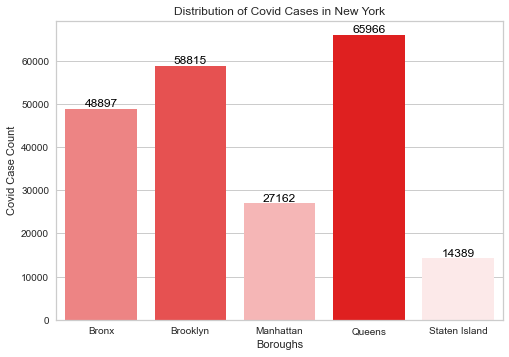

In [12]:
#plotting bar graph with colourpallete increasing shade along with the number of cases
pal=sns.light_palette("red",len(covid_boroughs))
rank=covid_boroughs['COVID_CASE_COUNT'].argsort().argsort()
plot=sns.barplot(x='BOROUGH_GROUP',y='COVID_CASE_COUNT',data=covid_boroughs,palette=np.array(pal[::1])[rank])
for index, row in covid_boroughs.iterrows():
    plot.text(index,(row.COVID_CASE_COUNT+0.01*row.COVID_CASE_COUNT), round(row.COVID_CASE_COUNT,2), color='black', ha="center",va='baseline')
plt.rcParams["axes.labelsize"] = 10
plot.set(xlabel='Boroughs',ylabel='Covid Case Count')    
plot.set_title("Distribution of Covid Cases in New York")

In [13]:
#splitting the data according to boroughs
man_df=covid_df.loc[covid_df['BOROUGH_GROUP']=='Manhattan']
stat_df=covid_df.loc[covid_df['BOROUGH_GROUP']=='Staten Island']
brx_df=covid_df.loc[covid_df['BOROUGH_GROUP']=='Bronx']
qun_df=covid_df.loc[covid_df['BOROUGH_GROUP']=='Queens']
brkn_df=covid_df.loc[covid_df['BOROUGH_GROUP']=='Brooklyn']
boros=[man_df,stat_df,brx_df,qun_df,brkn_df]

In [14]:
#sorting each borough data according to case count
for i,bros in enumerate(boros):
    bros.sort_values(['COVID_CASE_COUNT'],ascending=False,inplace=True)

<ipython-input-14-ba5247dfa82c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bros.sort_values(['COVID_CASE_COUNT'],ascending=False,inplace=True)


In [15]:
man_df.head()

,MODIFIED_ZCTA,NEIGHBORHOOD_NAME,BOROUGH_GROUP,COVID_CASE_COUNT,COVID_CASE_RATE,POP_DENOMINATOR,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE,TOTAL_COVID_TESTS,lat,long
25,10029,East Harlem,Manhattan,1942,2463.17,78841.52,212,268.89,12.83,15138,40.79,-73.95
28,10032,Washington Heights (South),Manhattan,1678,2728.79,61492.57,174,282.96,13.83,12129,40.84,-73.94
21,10025,Manhattan Valley/Morningside Heights/Upper Wes...,Manhattan,1483,1606.13,92333.47,176,190.61,7.22,20529,40.80,-73.97
29,10033,Washington Heights (North)/Washington Heights ...,Manhattan,1460,2465.78,59210.43,120,202.67,13.78,10593,40.84,-73.94
27,10031,Hamilton Heights/West Harlem,Manhattan,1448,2391.14,60556.93,132,217.98,12.71,11391,40.83,-73.95


In [16]:
CLIENT_ID = 'IBPL0HB5LEJSGOJ05ASSY5WX25MW3AAVVUMRABWHZE5TTM5H' # Foursquare ID
CLIENT_SECRET = 'B4JF4M4JYFDW0YCK0S5MO24JHGVUORJ0O0NBOZ3LMRZHAGCV' #  Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=100

In [17]:
#functions for gettting venue details within 500 m
def makeRequest(url):
    return requests.get(url, timeout=1000)

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    ul = []
    isfail = True
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        time.sleep(1)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        #try exception block since server was getting timed out before data gets captured
        try:
            print(url)
            response = makeRequest(url)
        except:
            try:
                time.sleep(3)
                response = makeRequest(url)
            except:
                ul.append(url)
               
                pass
        
        if(isfail):
            print("status code"+str(response.status_code))
            response_body = json.loads(response.content)
    #         print(response_body)
            results = response_body["response"]['groups'][0]['items']
    #         results = requests.get(url).json()["response"]['groups'][0]['items']

            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                      'Neighborhood Latitude', 
                      'Neighborhood Longitude', 
                      'Venue', 
                      'Venue Latitude', 
                      'Venue Longitude', 
                      'Venue Category']
    print(ul)
    return(nearby_venues)

In [18]:
#geting nearby venue data
qun_venues = getNearbyVenues(names=qun_df['NEIGHBORHOOD_NAME'],
                                   latitudes=qun_df['lat'],
                                   longitudes=qun_df['long']
                                  )

Corona/North Corona
https://api.foursquare.com/v2/venues/explore?&client_id=IBPL0HB5LEJSGOJ05ASSY5WX25MW3AAVVUMRABWHZE5TTM5H&client_secret=B4JF4M4JYFDW0YCK0S5MO24JHGVUORJ0O0NBOZ3LMRZHAGCV&v=20180605&ll=40.75,-73.85&radius=500&limit=100
status code200
Elmhurst
https://api.foursquare.com/v2/venues/explore?&client_id=IBPL0HB5LEJSGOJ05ASSY5WX25MW3AAVVUMRABWHZE5TTM5H&client_secret=B4JF4M4JYFDW0YCK0S5MO24JHGVUORJ0O0NBOZ3LMRZHAGCV&v=20180605&ll=40.74,-73.88&radius=500&limit=100
status code200
Jackson Heights
https://api.foursquare.com/v2/venues/explore?&client_id=IBPL0HB5LEJSGOJ05ASSY5WX25MW3AAVVUMRABWHZE5TTM5H&client_secret=B4JF4M4JYFDW0YCK0S5MO24JHGVUORJ0O0NBOZ3LMRZHAGCV&v=20180605&ll=40.75,-73.88&radius=500&limit=100
status code200
Edgemere/Far Rockaway
https://api.foursquare.com/v2/venues/explore?&client_id=IBPL0HB5LEJSGOJ05ASSY5WX25MW3AAVVUMRABWHZE5TTM5H&client_secret=B4JF4M4JYFDW0YCK0S5MO24JHGVUORJ0O0NBOZ3LMRZHAGCV&v=20180605&ll=40.6,-73.76&radius=500&limit=100
status code200
Woodside
h

status code200
Belle Harbor-Neponsit/Rockaway Park
https://api.foursquare.com/v2/venues/explore?&client_id=IBPL0HB5LEJSGOJ05ASSY5WX25MW3AAVVUMRABWHZE5TTM5H&client_secret=B4JF4M4JYFDW0YCK0S5MO24JHGVUORJ0O0NBOZ3LMRZHAGCV&v=20180605&ll=40.58,-73.85&radius=500&limit=100
status code200
Ozone Park
https://api.foursquare.com/v2/venues/explore?&client_id=IBPL0HB5LEJSGOJ05ASSY5WX25MW3AAVVUMRABWHZE5TTM5H&client_secret=B4JF4M4JYFDW0YCK0S5MO24JHGVUORJ0O0NBOZ3LMRZHAGCV&v=20180605&ll=40.69,-73.85&radius=500&limit=100
status code200
Astoria (South)
https://api.foursquare.com/v2/venues/explore?&client_id=IBPL0HB5LEJSGOJ05ASSY5WX25MW3AAVVUMRABWHZE5TTM5H&client_secret=B4JF4M4JYFDW0YCK0S5MO24JHGVUORJ0O0NBOZ3LMRZHAGCV&v=20180605&ll=40.76,-73.94&radius=500&limit=100
status code200
Cambria Heights
https://api.foursquare.com/v2/venues/explore?&client_id=IBPL0HB5LEJSGOJ05ASSY5WX25MW3AAVVUMRABWHZE5TTM5H&client_secret=B4JF4M4JYFDW0YCK0S5MO24JHGVUORJ0O0NBOZ3LMRZHAGCV&v=20180605&ll=40.69,-73.74&radius=500&limit=1

In [ ]:
#save to csv as limited number of calls perday
qun_venues.to_csv('qun_venues.csv',index=False)

In [19]:
qun_ven=pd.read_csv('qun_venues.csv')

In [20]:
qun_ven

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Corona/North Corona,40.750,-73.850,Arthur Ashe Stadium,40.749892,-73.847037,Tennis Stadium
1,Corona/North Corona,40.750,-73.850,Practice Courts (1-5) - USTA Billie Jean King ...,40.749114,-73.848187,Tennis Stadium
2,Corona/North Corona,40.750,-73.850,Queens Night Market,40.747777,-73.850827,Street Food Gathering
3,Corona/North Corona,40.750,-73.850,Grandstand - Billie Jean King National Tennis ...,40.748027,-73.848097,Tennis Stadium
4,Corona/North Corona,40.750,-73.850,US Open Player's Lounge,40.749970,-73.847905,Tennis Stadium
5,Corona/North Corona,40.750,-73.850,Court 4 - USTA Billie Jean King National Tenni...,40.748785,-73.847987,Tennis Stadium
6,Corona/North Corona,40.750,-73.850,Court 7 - USTA Billie Jean King National Tenni...,40.748551,-73.847287,Tennis Stadium
7,Corona/North Corona,40.750,-73.850,USTA Billie Jean King National Tennis Center,40.749415,-73.846017,Tennis Stadium
8,Corona/North Corona,40.750,-73.850,Court 5 - USTA Billie Jean King National Tenni...,40.748883,-73.847686,Tennis Stadium
9,Corona/North Corona,40.750,-73.850,US Open Player's Restaurant,40.749462,-73.847856,Restaurant


In [21]:
#function for getting the most common venues in order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [22]:
#class for analysis
class getanalysis():
    def __init__(self,venue_df, boro_df):
        self.v = venue_df
        self.b = boro_df
        self.bro=None
        self.nei=None
        self.clu=None
        self.num=None
    def groupbyven(self):#groupby venues and make a one hot encoded data  with frequency measured into one data frame
        boro_onehot = pd.get_dummies(self.v[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
        boro_onehot['Neighborhood'] = self.v['Neighborhood'] 

# move neighborhood column to the first column
        fixed_columns = [boro_onehot.columns[-1]] + list(boro_onehot.columns[:-1])
        boro_onehot = boro_onehot[fixed_columns]
        boro_grouped = boro_onehot.groupby('Neighborhood').mean().reset_index()
        self.bro=boro_grouped
        return (boro_grouped)
    
    def top10ven(self):#get top 10 venues
        num_top_venues = 10

        indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
        columns = ['Neighborhood']
        for ind in np.arange(num_top_venues):
            try:
                columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
            except:
                columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
        neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
        neighborhoods_venues_sorted['Neighborhood'] = self.bro['Neighborhood']
        
        for ind in np.arange(self.bro.shape[0]):
            neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(self.bro.iloc[ind, :], num_top_venues)
            self.nei=neighborhoods_venues_sorted
        return (neighborhoods_venues_sorted)

In [23]:
queens=getanalysis(qun_ven,qun_df)
queen_g=queens.groupbyven()
queen_top=queens.top10ven()

In [27]:
#class to do cluster analysis
class covid():
    def __init__(self,cov_df,top_df,grouped_df):
        self.c=cov_df
        self.t=top_df
        self.g=grouped_df
        self.nor=None
        self.temp=None
        self.no=None
    def preprocess(self):#preprocess the data by normalizing
        covidcluster=self.c.iloc[:,3:10]
        covidcluster.insert(0, 'NEIGHBORHOOD_NAME', self.c['NEIGHBORHOOD_NAME'])
        covidcluster.drop(['POP_DENOMINATOR','TOTAL_COVID_TESTS'],axis=1,inplace=True)
        temp=self.t
        temp=temp.merge(covidcluster,left_on='Neighborhood',right_on='NEIGHBORHOOD_NAME')
        temp.drop('NEIGHBORHOOD_NAME',axis=1,inplace=True)
        self.temp=temp
        ne=self.g.merge(covidcluster,how='left', left_on='Neighborhood', right_on='NEIGHBORHOOD_NAME',copy=False)
        ne.drop(['NEIGHBORHOOD_NAME','Neighborhood'],axis=1,inplace=True)
        new=preprocessing.normalize(ne)
        self.nor=new
        
    def elbow(self):#Elbow visualizer
        model = KElbowVisualizer(KMeans(), k=10)
        model.fit(self.nor)
        model.show()
    def idealcluster(self,num):#making the clusters
        kmeans = KMeans(n_clusters=num, random_state=0).fit(self.nor)
        self.no=num
        self.temp.insert(0, 'Cluster Labels', kmeans.labels_)
        return(self.temp,kmeans.labels_)
    def plotit(self):#map the clusters
        test = folium.Map(location=[40.7127281, -74.0060152], zoom_start=11)

# set color scheme for the clusters
        x = np.arange(self.no)
        ys = [i + x + (i*x)**2 for i in range(self.no)]
        colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
        rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
        markers_colors = []
        for lat, lon, poi, cluster in zip(self.c['lat'],self.c['long'], self.c['NEIGHBORHOOD_NAME'], self.temp['Cluster Labels']):
            label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
            if math.isnan(cluster):
                cluster=0
            folium.CircleMarker(
                 [lat, lon],
                 radius=5,
                 popup=label,
                 color=rainbow[int(cluster)-1],
                 fill=True,
                 fill_color=rainbow[int(cluster)-1],
                 fill_opacity=0.7).add_to(test)
        return(test)
    def Showclusters(self):#display each cluster along with data
        for n in range(self.no):
            display(self.temp[self.temp['Cluster Labels']==n])

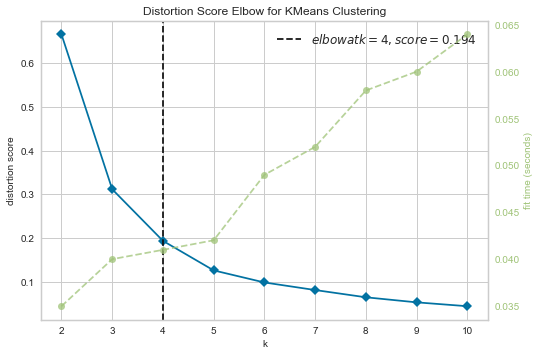

In [28]:
queens_covid=covid(qun_df,queen_top,queen_g)
qun_dat=queens_covid.preprocess()
queens_covid.elbow()

In [29]:
cluster,labels=queens_covid.idealcluster(4)
queens_covid.plotit()

In [30]:
queens_covid.Showclusters()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,COVID_CASE_COUNT,COVID_CASE_RATE,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE
0,0,Airport/East Elmhurst,Bus Station,Gas Station,Pizza Place,Donut Shop,Bakery,Supermarket,Mexican Restaurant,Chinese Restaurant,Peruvian Restaurant,Bank,1706,4678.81,179,490.92,21.77
4,0,Astoria (North),Pizza Place,Deli / Bodega,Italian Restaurant,Grocery Store,Peruvian Restaurant,Chinese Restaurant,Sandwich Place,Restaurant,Residential Building (Apartment / Condo),Diner,687,2105.24,80,245.15,10.86
5,0,Astoria (North)/Astoria (South),Bar,Pizza Place,Pharmacy,Playground,Chinese Restaurant,Coffee Shop,New American Restaurant,German Restaurant,Lounge,Fast Food Restaurant,628,1716.52,52,142.13,9.37
6,0,Astoria (South),Hotel,Breakfast Spot,Park,Caribbean Restaurant,Organic Grocery,Pizza Place,Gas Station,Supermarket,Dance Studio,Deli / Bodega,743,1921.66,53,137.08,10.68
7,0,Astoria (South)/Long Island City/Sunnyside,Rental Car Location,Coffee Shop,Theater,Recording Studio,Diner,Deli / Bodega,Dance Studio,Pet Service,Nightclub,New American Restaurant,706,2005.45,40,113.62,8.48
8,0,Auburndale/Fresh Meadows/Pomonok/Utopia,American Restaurant,Bank,Hotel,Kids Store,Chinese Restaurant,Coffee Shop,Pizza Place,Japanese Restaurant,Bus Line,Sporting Goods Shop,918,2083.96,67,152.10,13.24
9,0,Auburndale/Murray Hill,Korean Restaurant,Coffee Shop,Karaoke Bar,Liquor Store,Japanese Restaurant,Bank,Gastropub,Pizza Place,Donut Shop,Restaurant,621,1747.25,43,120.99,10.45
11,0,Bayside (North)/Bayside (South),Korean Restaurant,Bakery,Bar,American Restaurant,Coffee Shop,Indian Restaurant,Italian Restaurant,Asian Restaurant,Tea Room,Sushi Restaurant,485,1733.88,57,203.78,10.89
12,0,Bayside (South)/Oakland Gardens,Korean Restaurant,Chinese Restaurant,Yoga Studio,Bank,Dessert Shop,Supplement Shop,Supermarket,Shop & Service,Coffee Shop,Sandwich Place,490,1417.72,35,101.27,9.99
22,0,Ditmars Steinway,Deli / Bodega,Thai Restaurant,Chinese Restaurant,Cajun / Creole Restaurant,Food Truck,Coffee Shop,Bus Station,Burger Joint,Middle Eastern Restaurant,Brazilian Restaurant,533,1484.89,43,119.79,8.44


,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,COVID_CASE_COUNT,COVID_CASE_RATE,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE
21,1,Corona/North Corona,Tennis Stadium,Cocktail Bar,Latin American Restaurant,Mexican Restaurant,Spanish Restaurant,Hotel,Street Food Gathering,Candy Store,Clothing Store,Seafood Restaurant,4964,4448.26,444,397.87,21.06
26,1,Elmhurst,Chinese Restaurant,Bakery,Bubble Tea Shop,Thai Restaurant,Pharmacy,Vietnamese Restaurant,Supermarket,Taiwanese Restaurant,Fast Food Restaurant,Indonesian Restaurant,3425,3687.72,296,318.71,17.45
28,1,Flushing/Murray Hill/Queensboro Hill,Chinese Restaurant,Soccer Field,Korean Restaurant,Grocery Store,Indian Restaurant,Health & Beauty Service,Farmers Market,Coffee Shop,Cantonese Restaurant,Furniture / Home Store,1528,1909.67,168,209.96,12.29
31,1,Glendale/Ridgewood,Pizza Place,Discount Store,Deli / Bodega,Bar,German Restaurant,Supermarket,Fast Food Restaurant,Chinese Restaurant,Sandwich Place,Pharmacy,2366,2298.65,142,137.96,14.45
58,1,Woodside,Park,Discount Store,Italian Restaurant,Hardware Store,Donut Shop,Deli / Bodega,Restaurant,Electronics Store,Coffee Shop,Burger Joint,2437,2818.37,195,225.52,14.14


,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,COVID_CASE_COUNT,COVID_CASE_RATE,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE
2,2,Arverne/Broad Channel,Beach,Surf Spot,Garden Center,Food,Metro Station,Construction & Landscaping,Playground,Pizza Place,Deli / Bodega,Chinese Restaurant,346,2794.54,29,234.22,17.00
3,2,Arverne/Edgemere,Surf Spot,Bus Stop,Beach,Metro Station,Café,Board Shop,Taco Place,Supermarket,Brewery,Caribbean Restaurant,672,3339.92,93,462.22,15.97
10,2,Bayside (North),Clothing Store,Donut Shop,Lingerie Store,American Restaurant,Cosmetics Shop,Shoe Store,Women's Store,Mobile Phone Shop,Kids Store,Bus Stop,336,1781.25,27,143.14,9.86
13,2,Belle Harbor-Neponsit/Rockaway Park,Beach,Pub,Spa,Bakery,Chinese Restaurant,Smoke Shop,Mexican Restaurant,Pharmacy,Event Space,Bagel Shop,766,3763.06,88,432.31,18.39
14,2,Bellerose,Indian Restaurant,Cosmetics Shop,Hookah Bar,Thai Restaurant,Pizza Place,Convenience Store,Gym / Fitness Center,Food Court,Food & Drink Shop,Filipino Restaurant,521,2558.53,34,166.97,17.38
15,2,Bellerose/Douglaston-Little Neck,Department Store,Grocery Store,Sandwich Place,Pet Store,Park,Supermarket,Middle Eastern Restaurant,Gift Shop,Diner,American Restaurant,616,3283.84,68,362.50,13.74
16,2,Bellerose/Hollis Hills/Holliswood,Pizza Place,Intersection,Martial Arts Dojo,Donut Shop,Sandwich Place,Scenic Lookout,Convenience Store,Farmers Market,Fast Food Restaurant,Food,828,3567.06,51,219.71,18.56
17,2,Breezy Point,Bar,Pharmacy,Diner,Café,Grocery Store,Basketball Court,Convenience Store,Bank,Clothing Store,Yoga Studio,111,3138.53,4,113.10,7.92
19,2,Cambria Heights,Pharmacy,Business Service,Playground,Park,Yoga Studio,Fish Market,Fruit & Vegetable Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,720,3513.18,50,243.97,21.49
20,2,College Point,Gym,Convenience Store,Donut Shop,Fried Chicken Joint,Chinese Restaurant,Latin American Restaurant,Park,Liquor Store,Pizza Place,Bakery,610,2615.47,42,180.08,15.83


,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,COVID_CASE_COUNT,COVID_CASE_RATE,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE
1,3,Airport/South Jamaica/Springfield Gardens/St. ...,Southern / Soul Food Restaurant,Japanese Restaurant,Laundromat,Breakfast Spot,Chinese Restaurant,Gym,Pharmacy,Sandwich Place,Market,Bus Station,2212,3275.28,196,290.22,19.62
18,3,Briarwood/Jamaica,Sandwich Place,Donut Shop,Pizza Place,Fast Food Restaurant,Bank,Coffee Shop,Bus Station,Bus Stop,Fried Chicken Joint,Mobile Phone Shop,1725,2991.48,150,260.13,18.27
25,3,Edgemere/Far Rockaway,Beach,Donut Shop,Food & Drink Shop,Chinese Restaurant,Metro Station,Convenience Store,Food Truck,Food,Food Court,Yoga Studio,2571,3970.10,372,574.44,17.59
27,3,Flushing/Murray Hill,Deli / Bodega,College Track,Park,Fish & Chips Shop,Furniture / Home Store,Fruit & Vegetable Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,1358,2446.04,295,531.36,12.15
29,3,Forest Hills,Bakery,Yoga Studio,Pizza Place,Boxing Gym,Sushi Restaurant,Laundromat,Grocery Store,Health & Beauty Service,Indian Restaurant,Juice Bar,1524,2160.08,181,256.54,13.09
33,3,Hillcrest/Jamaica Estates/Jamaica Hills,Frozen Yogurt Shop,Yoga Studio,Fish & Chips Shop,Garden Center,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,1933,3058.77,254,401.93,18.23
35,3,Jackson Heights,South American Restaurant,Bakery,Mexican Restaurant,Mobile Phone Shop,Latin American Restaurant,Pizza Place,Peruvian Restaurant,Shoe Store,Bubble Tea Shop,Chinese Restaurant,2733,4368.41,257,410.79,18.17
50,3,Richmond Hill/South Ozone Park,Caribbean Restaurant,Discount Store,Nightclub,Grocery Store,Deli / Bodega,Fast Food Restaurant,Bakery,Bank,Donut Shop,Sandwich Place,1285,2527.10,98,192.73,19.85
53,3,South Ozone Park,Caribbean Restaurant,Bus Stop,Supermarket,Seafood Restaurant,Lounge,Latin American Restaurant,Chinese Restaurant,Yoga Studio,Food Court,Food & Drink Shop,1445,2984.57,107,221.00,19.99


In [31]:
#Calculating the frequency of gatherspots across the neighbourhoods and storing them in a dataframe
Gatherspots=['Airport Tram','Bus Stop','Bus Line','Tennis Court','College Track','Park','Bank','Bar','Baseball Field','Basketball Court','Boxing Gym','Bus Station','Cocktail Bar','Dance Studio','Event Space','Farmers Market','Fish Market','Flea Market','Food Court','Gay Bar','Gastropub','General Entertainment','General Travel','Gym','Gym / Fitness Center','Hookah Bar','Hotel Bar','Indoor Play Area','Indie Theater','Karaoke Bar','Library','Lounge','Market','Martial Arts Dojo','Metro Station','Movie Theater','Music Venue','Nightclub','Performing Arts Venue','Pub','Recreation Center','Soccer Field','Street Food Gathering','Tennis Stadium','Theater','Train Station','Yoga Studio']
test=queen_g
test['Gatherspots Total']=test.loc[:,Gatherspots].sum(axis=1)
s=test[['Neighborhood','Gatherspots Total']]
b=cluster.merge(s,how='left', left_on='Neighborhood', right_on='Neighborhood',copy=False)
h=(b[b['Cluster Labels']==0])
j=(b[b['Cluster Labels']==1])
k=(b[b['Cluster Labels']==2])
l=(b[b['Cluster Labels']==3])
cluster_0=h['Gatherspots Total'].mean()
cluster_1=j['Gatherspots Total'].mean()
cluster_2=k['Gatherspots Total'].mean()
cluster_3=l['Gatherspots Total'].mean()
score=[cluster_0,cluster_1,cluster_2,cluster_3]
labe=['Cluster 0','Cluster 1','Cluster 2','Cluster 3']
scr=pd.DataFrame(score,columns=['Score'])
scr.insert(0,'Clusters',labe)

Text(0.5, 1.0, 'Occurence of Gathering venues in each cluster')

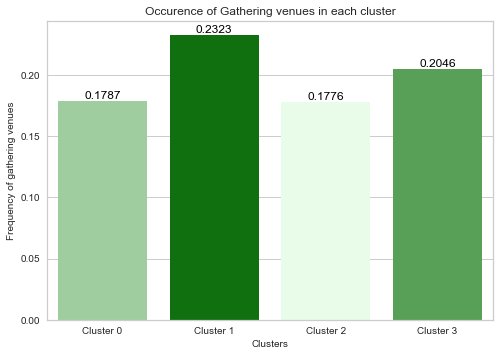

In [32]:
#bar plot with increasing shades with increase in frequency
pal=sns.light_palette("green",len(score))
rank=scr['Score'].argsort().argsort()
plot=sns.barplot(x='Clusters',y='Score',data=scr,palette=np.array(pal[::1])[rank])
for index, row in enumerate(scr['Score']):
    plot.text(index,(row +0.01*row), round(row,4), color='black', ha="center",va='baseline')
    plt.rcParams["axes.labelsize"] = 12
plot.set(xlabel='Clusters',ylabel='Frequency of gathering venues')    
plot.set_title("Occurence of Gathering venues in each cluster")

In [49]:
#get bar plots with change in gradient according to the weight of the parameter according to clusters
class getplots():
    def __init__(self,para):
        self.para=para
    def ploty(self,y,title,clr):
        #finding mean of each parameter in each cluster
        cluster_0=h[self.para].mean()
        cluster_1=j[self.para].mean()
        cluster_2=k[self.para].mean()
        cluster_3=l[self.para].mean()
        labe=['Cluster 0','Cluster 1','Cluster 2','Cluster 3']
        score=[cluster_0,cluster_1,cluster_2,cluster_3]
        scr1=pd.DataFrame(score,columns=[self.para])
        scr1.insert(0,'Clusters',labe)
        pal=sns.light_palette(clr,len(scr1))
        rank=scr1[self.para].argsort().argsort()
        plot=sns.barplot(x='Clusters',y=self.para,data=scr1,palette=np.array(pal[::1])[rank])
        for index, row in enumerate(scr1[self.para]):
            plot.text(index,(row +0.01*row), round(row,4), color='black', ha="center",va='baseline')
        plt.rcParams["axes.labelsize"] = 12
        plot.set(xlabel='Clusters',ylabel=y)    
        plot.set_title(title)
        plt.show()

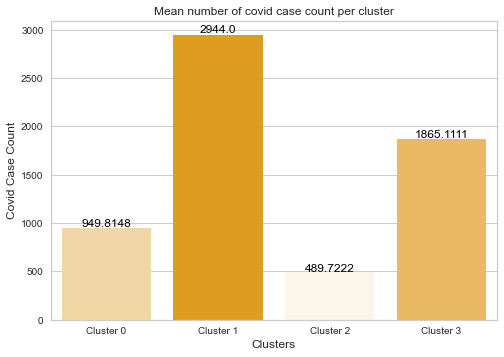

In [44]:
#plot for covid case count according to clusters
qun_casenum=getplots('COVID_CASE_COUNT')
qun_casenum.ploty('Covid Case Count','Mean number of covid case count per cluster','orange')

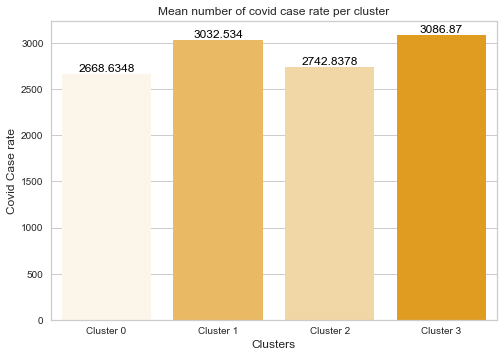

In [45]:
#plot for covid case rate according to clusters
qun_caserate=getplots('COVID_CASE_RATE')
qun_caserate.ploty('Covid Case rate','Mean number of covid case rate per cluster','orange')

In [47]:
#function to get medical centre category venues near a particular location

def getNearbymeds(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    ul = []
    isfail = True
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        time.sleep(1)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&categoryId=4bf58dd8d48988d104941735&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        #try exception block to capture responses  that got timed out
        try:
            print(url)
            response = makeRequest(url)
        except:
            try:
                print("retry start")
                time.sleep(3)
                print(url)
                response = makeRequest(url)
            except:
                ul.append(url)
                
                pass
        
            print("status code"+str(response.status_code))
            response_body = json.loads(response.content)

            results = response_body["response"]['venues']
            venues_list.append([(
            name, 
            lat, 
            lng, 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',  
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    #prints urls that didnt get captured
    print(ul)
    return(nearby_venues)

In [48]:
#get medical centre category venues near each neighbourhood
queens_hosp=getNearbymeds(names=qun_df['NEIGHBORHOOD_NAME'],
                                   latitudes=qun_df['lat'],
                                   longitudes=qun_df['long']
                                  )

Corona/North Corona
https://api.foursquare.com/v2/venues/search?&categoryId=4bf58dd8d48988d104941735&client_id=IBPL0HB5LEJSGOJ05ASSY5WX25MW3AAVVUMRABWHZE5TTM5H&client_secret=B4JF4M4JYFDW0YCK0S5MO24JHGVUORJ0O0NBOZ3LMRZHAGCV&v=20180605&ll=40.75,-73.85&radius=500&limit=100
retry start
https://api.foursquare.com/v2/venues/search?&categoryId=4bf58dd8d48988d104941735&client_id=IBPL0HB5LEJSGOJ05ASSY5WX25MW3AAVVUMRABWHZE5TTM5H&client_secret=B4JF4M4JYFDW0YCK0S5MO24JHGVUORJ0O0NBOZ3LMRZHAGCV&v=20180605&ll=40.75,-73.85&radius=500&limit=100
status code200
Elmhurst
https://api.foursquare.com/v2/venues/search?&categoryId=4bf58dd8d48988d104941735&client_id=IBPL0HB5LEJSGOJ05ASSY5WX25MW3AAVVUMRABWHZE5TTM5H&client_secret=B4JF4M4JYFDW0YCK0S5MO24JHGVUORJ0O0NBOZ3LMRZHAGCV&v=20180605&ll=40.74,-73.88&radius=500&limit=100
retry start
https://api.foursquare.com/v2/venues/search?&categoryId=4bf58dd8d48988d104941735&client_id=IBPL0HB5LEJSGOJ05ASSY5WX25MW3AAVVUMRABWHZE5TTM5H&client_secret=B4JF4M4JYFDW0YCK0S5MO24JH

retry start
https://api.foursquare.com/v2/venues/search?&categoryId=4bf58dd8d48988d104941735&client_id=IBPL0HB5LEJSGOJ05ASSY5WX25MW3AAVVUMRABWHZE5TTM5H&client_secret=B4JF4M4JYFDW0YCK0S5MO24JHGVUORJ0O0NBOZ3LMRZHAGCV&v=20180605&ll=40.72,-73.86&radius=500&limit=100
status code200
Hollis/Holliswood
https://api.foursquare.com/v2/venues/search?&categoryId=4bf58dd8d48988d104941735&client_id=IBPL0HB5LEJSGOJ05ASSY5WX25MW3AAVVUMRABWHZE5TTM5H&client_secret=B4JF4M4JYFDW0YCK0S5MO24JHGVUORJ0O0NBOZ3LMRZHAGCV&v=20180605&ll=40.72,-73.77&radius=500&limit=100
Kew Gardens Hills/Pomonok
https://api.foursquare.com/v2/venues/search?&categoryId=4bf58dd8d48988d104941735&client_id=IBPL0HB5LEJSGOJ05ASSY5WX25MW3AAVVUMRABWHZE5TTM5H&client_secret=B4JF4M4JYFDW0YCK0S5MO24JHGVUORJ0O0NBOZ3LMRZHAGCV&v=20180605&ll=40.73,-73.83&radius=500&limit=100
Rosedale
https://api.foursquare.com/v2/venues/search?&categoryId=4bf58dd8d48988d104941735&client_id=IBPL0HB5LEJSGOJ05ASSY5WX25MW3AAVVUMRABWHZE5TTM5H&client_secret=B4JF4M4JYFDW0

retry start
https://api.foursquare.com/v2/venues/search?&categoryId=4bf58dd8d48988d104941735&client_id=IBPL0HB5LEJSGOJ05ASSY5WX25MW3AAVVUMRABWHZE5TTM5H&client_secret=B4JF4M4JYFDW0YCK0S5MO24JHGVUORJ0O0NBOZ3LMRZHAGCV&v=20180605&ll=40.78,-73.85&radius=500&limit=100
status code200
South Jamaica/South Ozone Park
https://api.foursquare.com/v2/venues/search?&categoryId=4bf58dd8d48988d104941735&client_id=IBPL0HB5LEJSGOJ05ASSY5WX25MW3AAVVUMRABWHZE5TTM5H&client_secret=B4JF4M4JYFDW0YCK0S5MO24JHGVUORJ0O0NBOZ3LMRZHAGCV&v=20180605&ll=40.67,-73.8&radius=500&limit=100
Kew Gardens
https://api.foursquare.com/v2/venues/search?&categoryId=4bf58dd8d48988d104941735&client_id=IBPL0HB5LEJSGOJ05ASSY5WX25MW3AAVVUMRABWHZE5TTM5H&client_secret=B4JF4M4JYFDW0YCK0S5MO24JHGVUORJ0O0NBOZ3LMRZHAGCV&v=20180605&ll=40.71,-73.83&radius=500&limit=100
retry start
https://api.foursquare.com/v2/venues/search?&categoryId=4bf58dd8d48988d104941735&client_id=IBPL0HB5LEJSGOJ05ASSY5WX25MW3AAVVUMRABWHZE5TTM5H&client_secret=B4JF4M4JYFDW

In [ ]:
#save to csv to overcome call limits
queens_hosp.to_csv("queens_meds.csv",index=False)

In [51]:
#import csv
queens_meds=pd.read_csv("queens_meds.csv")

In [52]:
f=getanalysis(queens_meds,qun_df)
g=f.groupbyven()
t=f.top10ven()

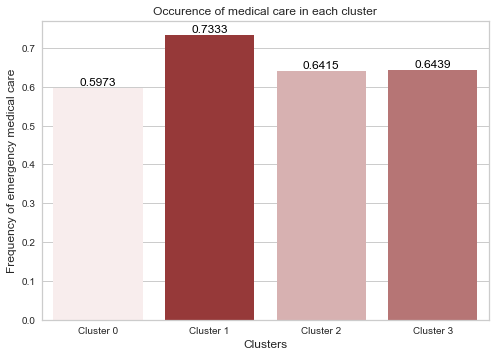

In [53]:
temp=g
#sorting urgent care and essential physical care for COVID
meds=['Urgent Care Center','Medical Lab','Medical Center','Hospital','Emergency Room',"Doctor's Office",'Hospital Ward']
#sum the frequency of said venues
temp['Medicalscore']=temp.loc[:,meds].sum(axis=1)
s1=temp[['Neighborhood','Medicalscore']]
b1=cluster.merge(s1,how='left', left_on='Neighborhood', right_on='Neighborhood',copy=False)
h=(b1[b1['Cluster Labels']==0])
j=(b1[b1['Cluster Labels']==1])
k=(b1[b1['Cluster Labels']==2])
l=(b1[b1['Cluster Labels']==3])
qun_meds=getplots('Medicalscore')
qun_meds.ploty('Frequency of emergency medical care',"Occurence of medical care in each cluster",'brown')